#                                                    XGBoost

In [1]:
import pandas as pd
import time
import numpy as np
from sklearn.cross_validation import train_test_split
import xgboost as xgb
from xgboost import plot_tree
from xgboost import plot_importance
import matplotlib.pyplot as plt
import gc

/home/shubham95pandey/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
#loading dataset
path = "mnt/ssd/kaggle-talkingdata2/competition_files/"

dtypes = {'ip'           : 'uint32',
          'app'          : 'uint16',
          'device'       : 'uint16',
          'os'           : 'uint16',
          'channel'      : 'uint16',
          'is_attributed': 'uint8' ,
          'click_id'     : 'uint32'
    
         }
print('loading train data...')

train_df = pd.read_csv(path+"train.csv", nrows=35000000, dtype = dtypes, usecols = ['ip','app','device','os','channel','click_time','is_attributed'])
# total observation : 184,903,891

loading train data...


In [6]:
# Getting Label
y = train_df['is_attributed']
train_df.drop(['is_attributed'], axis=1, inplace=True)

In [7]:
print('loading test data....')
test_df = pd.read_csv("testfolder/test.csv", dtype = dtypes , usecols =['ip','app','device','os','channel','click_time','click_id'])


loading test data....


In [8]:
sub = pd.DataFrame()
sub['click_id'] = test_df['click_id']
test_df.drop(['click_id'], axis=1, inplace = True)

len_train =len(train_df)
train_df = train_df.append(test_df)

del test_df
gc.collect()

208

In [9]:
print('Extracting day and hour...')
train_df['hour'] = pd.to_datetime(train_df.click_time).dt.hour.astype('uint8')
train_df['day']  = pd.to_datetime(train_df.click_time).dt.day.astype('uint8')
train_df.drop(['click_time'], axis=1, inplace=True)
gc.collect()

Extracting day and hour...


21

In [10]:
test = train_df[len_train:]
train = train_df[:(len_train)]
gc.collect()

print("train size: ", len(train))
print("test size: ", len(test))

train size:  35000000
test size:  18790469


In [12]:
"""
XGBoost parameters tuning guide:
https://github.com/dmlc/xgboost/blob/master/doc/how_to/param_tuning.md
https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
"""

params = {'eta': 0.6,
          'tree_method': "hist",       #Fast histogram optimized approximate greedy algorithm.
          'grow_policy': "lossguide",  #split at nodes with highest loss change
          'max_leaves' : 1400,         # Maximum number of nodes to be added .(for lossguide grow policy)
          'max_depth'  : 0,            # 0 means no limit (useful only for depth wise grow policy)
          'subsample'  : 0.9,
          'colsample_bytree':0.7,
          'colsample_bylevel':0.7,
          'min_child_weight':0,         #the larger the more conservative the algorithm will be
          'alpha':4,                    # L1 regularization on weights | default = 0| Large value == more conservative model
          'objective':'binary:logistic',
          'scale_pos_weight':9,         # because training data is extremely unbalanced
          'eval_metric' : 'auc',
          'nthread' : 8,
          'random_state' : 84,
          'silent': True
         }

In [13]:
#spliting data

x1, x2, y1, y2 =train_test_split(train, y, test_size=0.1, random_state =99)

del train
gc.collect()

1458

In [15]:
# watch list to observe the change in error in training and hold out data
start_time = time.time()

watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]

model = xgb.train(params, xgb.DMatrix(x1, y1), 50, watchlist, maximize=True, early_stopping_rounds = 20, verbose_eval =1)

del x1, x2, y1, y2
gc.collect()

print('[{}]: Training time for Histogram Optimized XGBoost model'.format(time.time() - start_time))

[0]	train-auc:0.95401	valid-auc:0.955059
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[1]	train-auc:0.957782	valid-auc:0.959427
[2]	train-auc:0.958375	valid-auc:0.958971
[3]	train-auc:0.959531	valid-auc:0.96021
[4]	train-auc:0.963337	valid-auc:0.963462
[5]	train-auc:0.964073	valid-auc:0.96379
[6]	train-auc:0.965765	valid-auc:0.964932
[7]	train-auc:0.965991	valid-auc:0.964598
[8]	train-auc:0.969168	valid-auc:0.965695
[9]	train-auc:0.971336	valid-auc:0.965428
[10]	train-auc:0.972852	valid-auc:0.9646
[11]	train-auc:0.974864	valid-auc:0.964651
[12]	train-auc:0.976739	valid-auc:0.964419
[13]	train-auc:0.976638	valid-auc:0.964046
[14]	train-auc:0.977648	valid-auc:0.96418
[15]	train-auc:0.979406	valid-auc:0.963
[16]	train-auc:0.980702	valid-auc:0.964162
[17]	train-auc:0.981193	valid-auc:0.963871
[18]	train-auc:0.982624	valid-auc:0.963185
[19]	train-auc:0.983098	valid-auc:0.96338
[20]	train-auc:0.

predicting....
Extraction feature importance matrix
Completed.....


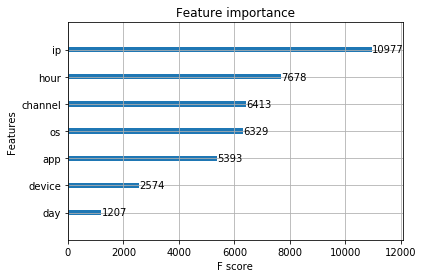

In [16]:
print("predicting....")
sub['is_attributed'] = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit)
sub.to_csv('sub_xgb_hist_pos_weight.csv', index = False)


#Model evaluation

print("Extraction feature importance matrix")

plot_importance(model)
plt.gcf().savefig('xgb_fe.png')

print("Completed.....")